In [1]:
import tensorflow as tf
import os 

from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import pandas as pd

import matplotlib.pyplot as plt



# 모델구성
from keras.models import Sequential

# 1D CNN
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Embedding

# LSTM
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Bidireictional, Attention
from tensorflow.keras.layers import Bidirectional, Attention

# GRU
from tensorflow.keras.layers import GRU

In [2]:
import konlpy
import gensim

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.tail()

,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


In [4]:
test_data.tail()

,id,document,label
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0
49999,6070594,마무리는 또 왜이래,0


In [5]:
train_data.drop_duplicates(subset=['document'], inplace=False)
train_data = train_data.dropna(how = 'any') 
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


### (2) 데이터로더 구성

- 데이터의 중복 제거 <br>
- NaN 결측치 제거 <br>
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [6]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    X_train= []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>','<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
print(len(X_train), len(y_train)) # 146182, 146182
print(len(X_test), len(y_test)) # 49157, 49157

146182 146182
49157 49157


In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### (3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포 <br>
- 적절한 최대 문장 길이 지정 <br>
- keras.preprocessing.sequence.pad_sequences 

num_tokens길이: 195339
문장길이 최소: 0
문장길이 최대: 116
문장길이 평균: 15.96940191154864
문장길이 표준편차: 12.843571191092


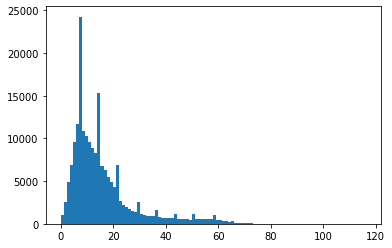

In [10]:
# 데이터셋 내 문장 길이 분포 확인
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print("num_tokens길이:", len(num_tokens))  # 195399
# print(num_tokens)



# 문장길이의 최소값, 최대값, 평균값, 표준편차
print('문장길이 최소:', np.min(num_tokens))
print('문장길이 최대:', np.max(num_tokens))
print('문장길이 평균:', np.mean(num_tokens))
print('문장길이 표준편차:', np.std(num_tokens))


plt.hist(num_tokens, bins=100)
plt.show()

In [11]:
# 최대 길이를 (평균 + 2*표준편차)로 한다면
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen :', maxlen)
ratio = np.sum(num_tokens<max_tokens)/len(num_tokens)
print(f'전체 문장의 {round(ratio, 4)}%가 설정 가능한 범위내의 비율')
# print('')

pad_sequences maxlen : 41
전체 문장의 0.9343%가 설정 가능한 범위내의 비율


In [12]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, 
                                                        value = word_to_index['<PAD>'],
                                                        padding='pre',  # 혹은 post
                                                        maxlen = maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)



print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [13]:
vocab_size = len(word_to_index)
# num_words = 10000

vocab_size

10000

### (4) 모델 구성 및 validation set 구성

(1) 1D CNN

In [14]:
word_vector_dim_cnn = 32


model1 = tf.keras.Sequential()
model1.add(Embedding(vocab_size, word_vector_dim_cnn, input_length = maxlen))
model1.add(Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.MaxPooling1D(5))
model1.add(Conv1D(16, 7, activation='relu'))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

(2) LSTM

In [15]:
word_vector_dim_lstm = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim_lstm, input_length=maxlen))   # trainable을 True로 주면 Fine-tuning
model2.add(tf.keras.layers.LSTM(16))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(8, activation='sigmoid')) 
model2.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 32)            320000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 323,281
Trainable params: 323,281
Non-trainable params: 0
_________________________________________________________________


(3) GRU

In [16]:
word_vector_dim_GRU = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GRU 레이어로 모델 설계
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim_GRU, input_length = maxlen))
model3.add(tf.keras.layers.GRU(16))  # GRU state 벡터의 차원수 (변경가능)
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(8, activation='sigmoid'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 32)            320000    
_________________________________________________________________
gru (GRU)                    (None, 16)                2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 322,545
Trainable params: 322,545
Non-trainable params: 0
_________________________________________________________________


(4) Bidirectional

In [17]:
word_vector_dim_Bi = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim_Bi, input_length=maxlen))   # trainable을 True로 주면 Fine-tuning
model4.add(tf.keras.layers.Bidirectional(LSTM(16)))
model4.add(tf.keras.layers.Dropout(0.2))
model4.add(tf.keras.layers.Dense(8, activation='sigmoid')) 
model4.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 32)            320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                6272      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 326,545
Trainable params: 326,545
Non-trainable params: 0
_________________________________________________________________


(5) Attention

In [18]:
# word_vector_dim_A = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model4 = tf.keras.Sequential()
# model4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim_A, input_length=maxlen))   # trainable을 True로 주면 Fine-tuning
# model4.add(tf.keras.layers.Attention(LSTM(16)))
# model4.add(tf.keras.layers.Dropout(0.2))
# model4.add(tf.keras.layers.Dense(8, activation='sigmoid')) 
# model4.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

# model4.summary()

In [19]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### (5) 모델 훈련개시

In [58]:
# 모델 바꿔가면서 실험 가능

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # overfitting 방지를 위해 epoch낮춤 

history = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

# model1_CNN (loss: 0.0077 - accuracy: 0.9969 - val_loss: 1.7336 - val_accuracy: 0.8419)
# model2_LSTM (loss: 0.2178 - accuracy: 0.9178 - val_loss: 0.3730 - val_accuracy: 0.8530)
# model_GRU (loss: 0.2402 - accuracy: 0.9103 - val_loss: 0.3522 - val_accuracy: 0.8561)
# model4 _Bidirectional (accuracy: 0.9795 - val_loss: 0.6503 - val_accuracy: 0.8319)

Epoch 1/10
266/266 [==============================] - 3s 7ms/step - loss: 0.4921 - accuracy: 0.7583 - val_loss: 0.3660 - val_accuracy: 0.8479
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3515 - accuracy: 0.8556 - val_loss: 0.3530 - val_accuracy: 0.8481
Epoch 3/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3273 - accuracy: 0.8679 - val_loss: 0.3522 - val_accuracy: 0.8498
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3126 - accuracy: 0.8751 - val_loss: 0.3471 - val_accuracy: 0.8508
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3004 - accuracy: 0.8812 - val_loss: 0.3431 - val_accuracy: 0.8575
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2888 - accuracy: 0.8869 - val_loss: 0.3437 - val_accuracy: 0.8572
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2764 - accuracy: 0.8927 - val_loss: 0.3421 - val_accuracy: 0.8585
Epoch 

### (6) Loss, Accuracy 그래프 시각화

In [59]:
# 모델 바꿔가면서 실험 가능
results = model3.evaluate(X_test, y_test, verbose=1)

print(results)

# model1_CNN [1.7589129209518433, 0.8123766779899597]
# model2_LSTM [0.3871341049671173, 0.8471835255622864]
# model3_GRU [0.36575549840927124, 0.8504993915557861]
# model4_Bidirectionl [0.6544740796089172, 0.8297292590141296]

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3658 - accuracy: 0.8505
[0.36575549840927124, 0.8504993915557861]


In [60]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


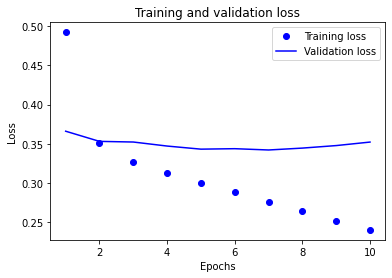

In [61]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

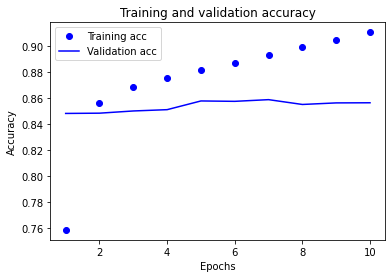

In [62]:
plt.clf()   # 그림초기화
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### (7)학습된 Embedding 레이어 분석

In [63]:
embedding_layer = model3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 32)


In [75]:
# 학습한 Embedding 파라미터를 파일에 써서 저장. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim_gru))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [76]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("재미")

[('이유리', 0.8802432417869568),
 ('오브', 0.876359224319458),
 ('제미', 0.8728829622268677),
 ('자랑', 0.8531790971755981),
 ('이리', 0.8524904847145081),
 ('are', 0.8511391878128052),
 ('박지윤', 0.8492029309272766),
 ('그러나', 0.8491440415382385),
 ('깊이', 0.8489816188812256),
 ('퍼', 0.8479810357093811)]

(1)model1_cnn = word_vectors.similar_by_word("재미") <br>
[('을까요', 0.7951483130455017), <br>
 ('메카', 0.7810143828392029), <br>
 ('영화사', 0.7779203057289124), <br>
 ('몰입', 0.7665661573410034), <br>
 ('설치', 0.7628231048583984), <br>
 ('양조위', 0.7556427121162415), <br>
 ('환호', 0.7555163502693176), <br>
 ('넴', 0.749825119972229), <br>
 ('파치노', 0.746423065662384), <br>
 ('막힌다', 0.7413306832313538)] <br>
 
(2)model2_lstm = word_vectors.similar_by_word("재미") <br>
[('완전', 0.8689649701118469), <br>
 ('되게', 0.8290510773658752), <br>
 ('가치', 0.8144718408584595), <br>
 ('공감', 0.8064895868301392), <br>
 ('이렇게', 0.8025048971176147), <br>
 ('너무', 0.7915762662887573), <br>
 ('최대', 0.7847070097923279), <br>
 ('매우', 0.778508722782135), <br>
 ('박진감', 0.7666275501251221), <br>
 ('투입', 0.7639314532279968)] <br>
 
 (3)model3_gru = word_vectors.similar_by_word("재미") <br>
 [('이유리', 0.8802432417869568), <br>
 ('오브', 0.876359224319458), <br>
 ('제미', 0.8728829622268677), <br>
 ('자랑', 0.8531790971755981), <br>
 ('이리', 0.8524904847145081), <br>
 ('are', 0.8511391878128052), <br>
 ('박지윤', 0.8492029309272766), <br>
 ('그러나', 0.8491440415382385), <br>
 ('깊이', 0.8489816188812256), <br>
 ('퍼', 0.8479810357093811)] <br>
 
(4)model4_Bidirection = word_vectors.similar_by_word("재미") <br>
[('매우', 0.8357694745063782), <br>
 ('공감', 0.8338692784309387), <br>
 ('시대', 0.8090060949325562), <br>
 ('긴장감', 0.8052788972854614), <br>
 ('집중', 0.7962589263916016), <br>
 ('매력', 0.7949312925338745), <br>
 ('완전', 0.7911649942398071), <br>
 ('제미', 0.7845884561538696), <br>
 ('몰입', 0.7674726247787476), <br>
 ('상태', 0.7565873861312866)]


### (8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [78]:
os.getcwd()

'/aiffel/aiffel/workplace/Aiffel_Quest/QUEST08'

In [79]:
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['재미']
vector.shape

(100,)

In [80]:
word_vectors.wv.vectors.shape

(302960, 100)

In [81]:
vocab_size = len(word_to_index)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim_gru = word_vector_dim  # 워드 벡터의 차원수, 위에서 명시해준 변수대로 변경가능
embedding_matrix = np.random.rand(vocab_size, word_vector_dim_gru)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv.vectors:
        embedding_matrix[i] = word_vectors.wv.vectors[index_to_word[i]]

/tmp/ipykernel_4076/797983952.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_to_word[i] in word_vectors.wv.vectors:


In [82]:
embedding_matrix.shape

(10000, 32)

In [89]:
from tensorflow.keras.initializers import Constant

vocab_size =  len(word_to_index)   # 어휘 사전의 크기입니다(10,000개의 단어)

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim_gru, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GRU(16))
model3.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()



# model3 = tf.keras.Sequential()
# model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim_GRU, input_length = maxlen))
# model3.add(tf.keras.layers.GRU(16))  # GRU state 벡터의 차원수 (변경가능)
# model3.add(tf.keras.layers.Dropout(0.2))
# model3.add(tf.keras.layers.Dense(8, activation='sigmoid'))
# model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 32)            320000    
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 322,545
Trainable params: 322,545
Non-trainable params: 0
_________________________________________________________________


In [90]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


# (1) CNN_0.9927
# (2) LSTM_0.9942
# (3) GRU_0.9810
# (4) Bidirectional(LSTM)_0.9969나옴

Epoch 1/50
266/266 [==============================] - 3s 7ms/step - loss: 0.5862 - accuracy: 0.6933 - val_loss: 0.4361 - val_accuracy: 0.8192
Epoch 2/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3963 - accuracy: 0.8359 - val_loss: 0.3693 - val_accuracy: 0.8467
Epoch 3/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3464 - accuracy: 0.8584 - val_loss: 0.3523 - val_accuracy: 0.8505
Epoch 4/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3232 - accuracy: 0.8687 - val_loss: 0.3407 - val_accuracy: 0.8532
Epoch 5/50
266/266 [==============================] - 1s 5ms/step - loss: 0.3062 - accuracy: 0.8761 - val_loss: 0.3374 - val_accuracy: 0.8528
Epoch 6/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2949 - accuracy: 0.8818 - val_loss: 0.3361 - val_accuracy: 0.8575
Epoch 7/50
266/266 [==============================] - 1s 5ms/step - loss: 0.2843 - accuracy: 0.8867 - val_loss: 0.3434 - val_accuracy: 0.8521
Epoch 

In [91]:
# 테스트셋으로 모델 평가
results = model.evaluate(X_test, y_test, verbose=1)

print(results)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.6455 - accuracy: 0.8314
[0.6455196738243103, 0.8314380645751953]
